# 核心、外围
## 基因数量.snp数量,h2作为细胞得分
* 性状基因与单细胞表达基因 基因数量的excess overlap 【Allcell_genenum是指单细胞表达数据的所有gene】
* 单细胞表达的性状相关基因上snp的数量
* 单细胞表达的性状相关基因上snp的数量与随机从性状相关基因中抽取相同数量的基因上snp的数量的zscore
* 单细胞表达的性状相关基因上平均每个snp的h2
* 单细胞表达的性状相关基因上平均每个基因的h2
* 单细胞表达的性状相关基因的h2coverage

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import time
from scipy.stats import hypergeom
import random

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 14

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [2]:
def makedir(folder_path):
    # 检查文件夹是否已经存在
    if not os.path.exists(folder_path):
        # 文件夹不存在时创建
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 已创建")
    else:
        print(f"文件夹 '{folder_path}' 已存在，不进行任何处理")

In [3]:
# 遍历文件夹中的指定格式的文件
def openFolderAll(folder_path,desired_extension):
    filelist = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(desired_extension):
            filelist.append(file_path)
    return filelist

## 计算每个单细胞上有表达的性状核心基因数量、对应的snp数量、h2（后验概率和)

In [5]:
# excess overlap
def excessOverlap(X,Y,N):
    return (len(set(X) & set(Y))/len(set(X))) / (len(set(N) & set(Y))/ len(set(N)))

In [4]:
# 读取asthma gwas数据中所有基因
trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\29_new.txt",sep = "\t")
trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\29.txt",header= None)[0])
trait_core = trait[trait["gene name"].isin(trait_coregene)]
trait_coregenelist = list(set(list(trait_core["gene name"])))   # 性状相关基因 12676  n
trait_coresnplist = list(set(list(trait_core["snp"])))   # 性状相关snp 205248
trait_coreunique = trait_core.drop_duplicates(["snp"])
trait_corepip = sum(trait_coreunique["posterior"])

In [6]:
tissuelist = os.listdir(r"E:\00_CeSOP\results\asthma\lcczscore-pip")
for tissue in tissuelist[0:1]:
    print(tissue)
    # 创建结果文件夹
    makedir(r"E:\00_CeSOP\results\asthma\other-index\other-index-core\%s"%(tissue))

    # 读取TS FACS单细胞数据
    filePath = r"E:\00_CeSOP\data\TS_FACS\TS_%s.h5ad"%tissue
    annData = sc.read_h5ad(filePath)
    # 单细胞数据中的所有基因  M
    scgene = list(annData.var.index)

    # 按照细胞类型进行分组
    obs_df = pd.DataFrame(annData.obs)
    grouped_adata = obs_df.groupby("cell_ontology_class")
    # 使用value_counts()方法计算每个分组中的细胞数量
    group_counts = obs_df["cell_ontology_class"].value_counts()
    # 将细胞类型按细胞数量逆序排列分组
    sorted_groups = group_counts.sort_values()
    celltypelist = list(sorted_groups.keys())

    num = 0
    for celltype in celltypelist:
        num +=1
        # 取出 'cd4-positive alpha-beta t cell' 对应的组的数据
        subset_annData = annData[annData.obs['cell_ontology_class'] == celltype, :]
        subset_annData_df = subset_annData.to_df()
        # 有表达的基因
        expressedGenes = subset_annData_df.apply(lambda row: subset_annData_df.columns[row.to_numpy().nonzero()[0]].tolist(), axis=1)
        celllist = list(expressedGenes.index)

        # 计算每个细胞中的结果
        result_list= []
        for cell in celllist:   #cell是细胞名字
            genelist = []
            # 单细胞有表达的基因  N
            singlecell_genelist = list(set(expressedGenes[cell]))
            # 单个细胞中有表达的asthma相关基因  k
            singlecell_asthma_genelist = list(set(trait_coregenelist) & set(singlecell_genelist))
            singlecell_asthma_genenum = len(singlecell_asthma_genelist)
            # 跳过该细胞
            if (singlecell_asthma_genenum == 0) :
                continue
            # singlecell_asthma_geneHpvalue = hypergeom.sf(len(singlecell_asthma_genelist)-1,len(scgene),len(singlecell_genelist),len(trait_genelist))
            # 性状基因与单细胞表达基因 基因数量的excess overlap
            singlecell_asthma_gene_excessoverlap = excessOverlap(singlecell_genelist,trait_coregenelist,scgene)

            # 单个细胞中有表达的asthma相关基因对应的snp
            singlecell_asthma_snplist = list(set(trait[trait["gene name"].isin(singlecell_asthma_genelist)]["snp"]))
            singlecell_asthma_snpnum = len(singlecell_asthma_snplist)
            # 单细胞表达的性状相关基因上snp的数量与随机从性状相关基因中抽取相同数量的基因上snp的数量的zscore
            population = trait_coregenelist     #样本集合
            num_samples = 10       # 抽样次数
            sample_size = singlecell_asthma_genenum   # 每次抽样的样本大小
            samples_result = []
            for _ in range(num_samples):
                sample = np.random.choice(list(population), size=sample_size, replace=False)
                # 计算抽样gene的snp数量
                sample_snplist = list(set(trait[trait["gene name"].isin(sample)]["snp"]))
                sample_snpnum = len(sample_snplist)
                samples_result.append(sample_snpnum)
            singlecell_asthma_snpnum_zscore = (singlecell_asthma_snpnum - np.mean(samples_result))/np.std(samples_result)

            # 单个细胞中有表达的asthma相关基因对应的snp上的后验概率
            singlecell_asthma_snp = trait[trait["gene name"].isin(singlecell_asthma_genelist)]
            singlecell_asthma_snpunique = singlecell_asthma_snp.drop_duplicates("snp")
            singlecell_asthma_pip = list(singlecell_asthma_snpunique["posterior"])
            singlecell_asthma_pipsum = sum(singlecell_asthma_pip)
            # 单细胞表达的性状相关基因上平均每个snp的h2
            singlecell_asthma_persnppip = singlecell_asthma_pipsum / singlecell_asthma_snpnum
            # 单细胞表达的性状相关基因上平均每个基因的h2
            singlecell_asthma_pergenepip = singlecell_asthma_pipsum / singlecell_asthma_genenum
            # 单细胞表达的性状相关基因的h2coverage
            h2coverage = (singlecell_asthma_pipsum/trait_corepip) / (singlecell_asthma_genenum/singlecell_asthma_genenum)

            result_list.append([cell,singlecell_asthma_genenum,singlecell_asthma_gene_excessoverlap,
                                singlecell_asthma_snpnum,singlecell_asthma_snpnum_zscore,
                                singlecell_asthma_pipsum,singlecell_asthma_persnppip,singlecell_asthma_pergenepip,h2coverage])
            # print(cell,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

        print("第" + str(num) + "/" + str(len(celltypelist)) +"个细胞类型:"+str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
        df_singcell = pd.DataFrame(result_list)
        df_singcell.columns = ["cell","genenum","genenum_excessoverlap","snpnum","snpnum_zscore",
                               "pip","persnppip","pergenepip","h2coverage"]
        df_singcell.to_csv(r"E:\00_CeSOP\results\asthma\other-index\other-index-core\%s\%s.csv"%(tissue,celltype))

Bladder
文件夹 'E:\00_CeSOP\results\asthma\other-index\core\Bladder' 已创建
第1/15个细胞类型:2024-05-05 16:43:52
第2/15个细胞类型:2024-05-05 16:44:04
第3/15个细胞类型:2024-05-05 16:44:21
第4/15个细胞类型:2024-05-05 16:45:10
第5/15个细胞类型:2024-05-05 16:46:02
第6/15个细胞类型:2024-05-05 16:47:01
第7/15个细胞类型:2024-05-05 16:48:58
第8/15个细胞类型:2024-05-05 16:51:47
第9/15个细胞类型:2024-05-05 16:54:17
第10/15个细胞类型:2024-05-05 16:57:04


OSError: Cannot save file into a non-existent directory: 'E:\00_CeSOP\results\asthma\other-index\core\Bladder'

## 将所有细胞分别按照基因数量/snp数量/h2排名，top10%的细胞被认为是性状相关的,看这些性状相关细胞在组织中的分布

In [13]:
# tissuelist = os.listdir(r"E:\00_CeSOP\results\asthma\other-index\other-index-core")
# 
# results_ct = pd.DataFrame()
# for tissue in tissuelist:
#     folder_path = r"E:\00_CeSOP\results\asthma\other-index\other-index-core\%s"%tissue
#     celltypelist = openFolderAll(folder_path,".csv")
# 
#     tissue_df = pd.DataFrame()
#     for ct in celltypelist:
#         df = pd.read_csv(ct)
#         celltype = ct.split("\\")[-1].split(".")[0]
#         df["celltype"] = celltype
#         tissue_df = tissue_df.append(df)
#     tissue_df["tissue"] = tissue
#     results_ct = results_ct.append(tissue_df)
# results_ct.to_csv(r"E:\00_CeSOP\results\asthma\other-index\other-index-core\allcells.csv")
# print("finish!")


finish!


In [8]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [9]:
# Fisher's 精确检验
from scipy.stats import fisher_exact

allcells_result_df= pd.read_csv(r"E:\00_CeSOP\results\asthma\other-index\other-index-core\allcells.csv")
tissuelist = os.listdir(r"E:\0_单细胞1\results\lcczscore-pip")

# for index in allcells_result_df.columns[3:-2]:
for index in allcells_result_df.columns[3:4]:
    result_index = []
    # topk 性状相关细胞
    results_ct_sorted_df = allcells_result_df.sort_values(by=index,ascending=False)
    results_ct_sorted_topk_df = results_ct_sorted_df.iloc[:int(len(results_ct_sorted_df) * (10 / 100))][[index,"tissue","celltype","cell"]]

    for tissue in tissuelist:
        tissue_cell = allcells_result_df[allcells_result_df['tissue']==tissue]
        tissue_cell_topk = results_ct_sorted_topk_df[results_ct_sorted_topk_df['tissue']==tissue]
        tissue_cellnum = len(tissue_cell)
        tissue_cellnum_topk = len(tissue_cell_topk)

        # 计算jaccard系数
        jaccard = jaccard_similarity(set(tissue_cell["cell"]),set(tissue_cell_topk["cell"]))

        # 计算fisher精确检验pvalue
        b = tissue_cellnum
        a = tissue_cellnum_topk
        observed_table = [[a, b-a], [np.floor(b/10), b - np.floor(b/10)]]  # 2x2 列联表数据
        odds_ratio, p_value = fisher_exact(observed_table, alternative='greater')

        # 所有细胞M中与性状相关的细胞有N个，那么某个组织的n个细胞中有k个性状相关细胞是否显著高
        M = len(allcells_result_df)
        N = len(results_ct_sorted_topk_df)
        n = tissue_cellnum
        k = tissue_cellnum_topk
        Hpvalue = hypergeom.sf(k-1,M,N,n)

        result_index.append([tissue,tissue_cellnum,tissue_cellnum_topk,
                       jaccard,p_value,Hpvalue])
    result_index_df = pd.DataFrame(result_index)
    result_index_df.columns = ["tissue","cellnum","relatedCellnum","jaccard","fisher's pvalue","hypergeom pvalue"]
    result_index_df.to_csv(r"E:\00_CeSOP\results\asthma\other-index\other-index-results/coregene/%s.csv"%index)

### 结果可视化
将组织按照jaccard系数排序，并标注显著性

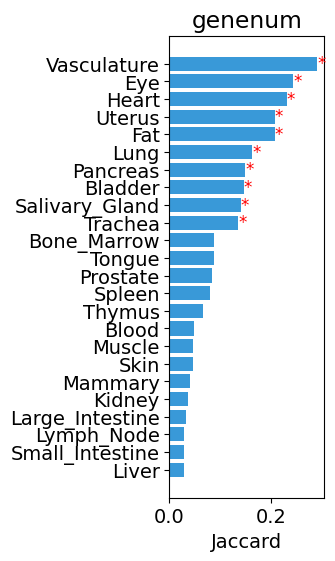

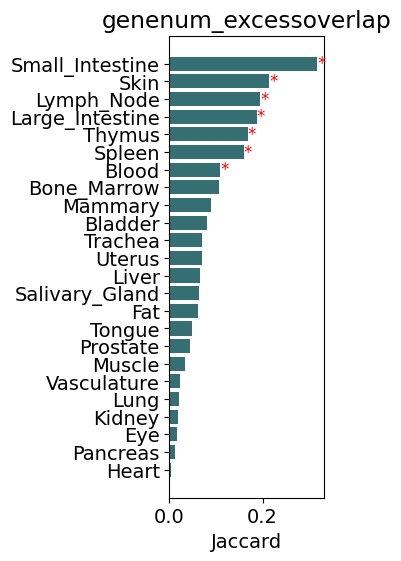

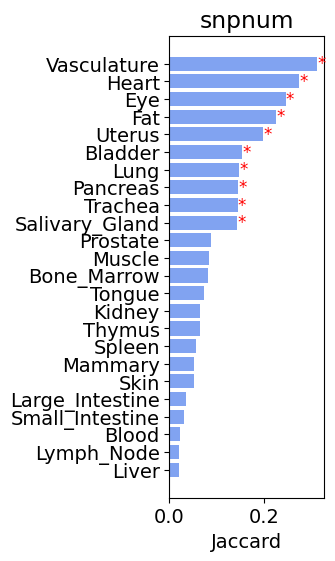

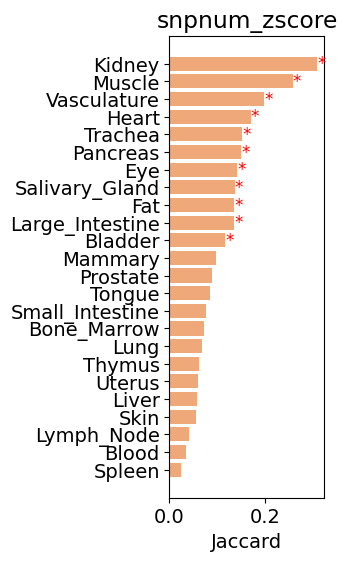

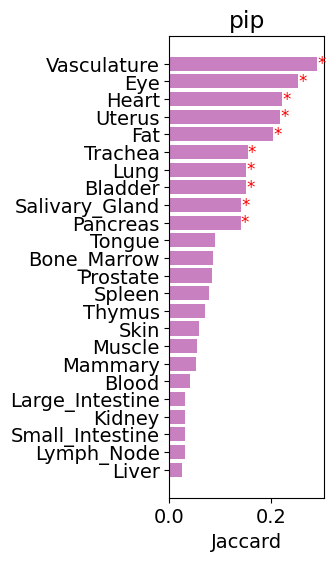

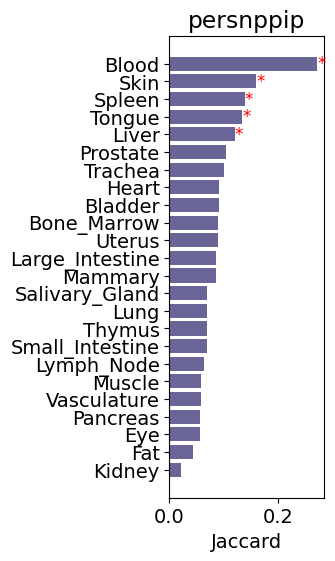

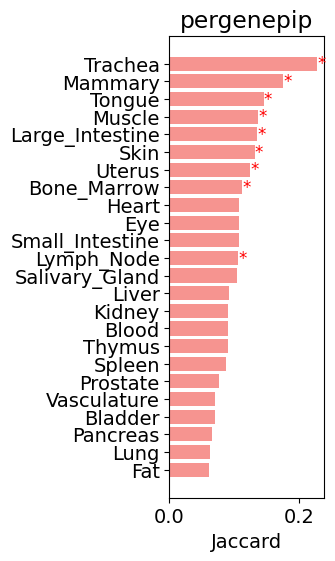

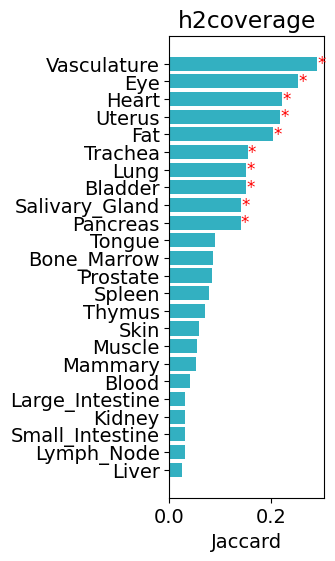

In [17]:
# 配色方案 ： e75840 - a565ef - 628cee - eb9358 - d05c7c - bb60b2 - 433e7c - f47a75 - 009db2 - 024b51- 0780cf - 765005
# https://zhuanlan.zhihu.com/p/622443724
allcells_result_df= pd.read_csv(r"E:\00_CeSOP\results\asthma\other-index\other-index-core\allcells.csv")
colors = ["#0780cf","#024b51","#628cee","#eb9358",
          "#bb60b2","#433e7c","#f47a75","#009db2"]
for i in range(8):
    index = allcells_result_df.columns[3:-2][i]
    result_index_df = pd.read_csv(r"E:\00_CeSOP\results\asthma\other-index\other-index-results/coregene/%s.csv"%index)
    result_index_df_sorted = result_index_df.sort_values(by = "jaccard")
    fig = plt.figure(figsize=(2,6))
    plt.barh(result_index_df_sorted["tissue"], result_index_df_sorted["jaccard"],color = colors[i],alpha = 0.8)
    plt.xlabel("Jaccard")
    plt.title(index)
    # 添加星号
    for i, value in enumerate(list(result_index_df_sorted["jaccard"])):
        if result_index_df_sorted[result_index_df_sorted["jaccard"]==value]["fisher's pvalue"].values[0] < 0.005:
            plt.text(value, i, "*", color='red', fontsize=12, va='center')
    # plt.axvline(x=0.005, color='green', linestyle='--')
    plt.savefig(r"E:\00_CeSOP\results\asthma\other-index\other-index-results/coregene/%s.jpg"%index, bbox_inches='tight')
    plt.show()